In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

from utils import get_fall_dataset, preprocess_df, print_rules, tree_to_rules

In [2]:
dataset = Path('WEDA-FALL/dataset/50Hz')

In [3]:
walking_dataset = dataset / 'D01'
walking_accel = (f for f in walking_dataset.glob('*_accel.csv') if 'vertical' not in f.name)
walking_gyro = walking_dataset.glob('*_gyro.csv')

In [4]:
jogging_dataset = dataset / 'D02'
jogging_accel = (f for f in jogging_dataset.glob('*_accel.csv') if 'vertical' not in f.name)
jogging_gyro = jogging_dataset.glob('*_gyro.csv')

In [5]:
df_list = []
for acc, gyro in zip(walking_accel, walking_gyro):
	df1 = pd.read_csv(acc)
	df2 = pd.read_csv(gyro)
	df = pd.concat([df1, df2], axis=1)
	df = preprocess_df(df).dropna()
	df['label'] = np.full(len(df), 'walking')
	df_list.append(df)
df_walking = pd.concat(df_list)

In [6]:
df_list = []
for acc, gyro in zip(jogging_accel, jogging_gyro):
	df1 = pd.read_csv(acc)
	df2 = pd.read_csv(gyro)
	df = pd.concat([df1, df2], axis=1)
	df = preprocess_df(df).dropna()
	df['label'] = np.full(len(df), 'jogging')
	df_list.append(df)
df_jogging = pd.concat(df_list)

In [7]:
df_fall = get_fall_dataset(dataset)
df_fall = df_fall[df_fall['label'] == 'fall']

df = pd.concat([df_walking, df_jogging, df_fall]).reset_index(drop=True)
# df = pd.concat([df_walking, df_jogging]).reset_index(drop=True)

In [8]:
df['label'].value_counts()

label
walking    61270
fall       43462
jogging    36897
Name: count, dtype: int64

In [9]:
X = df[['acceleration', 'rotationrate', 'angle_pitch']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.2, random_state=42, shuffle=False
)

              precision    recall  f1-score   support

        fall       0.54      0.77      0.64     43462
     jogging       0.87      0.65      0.74     36897
     walking       0.86      0.74      0.80     61270

    accuracy                           0.72    141629
   macro avg       0.76      0.72      0.72    141629
weighted avg       0.77      0.72      0.73    141629



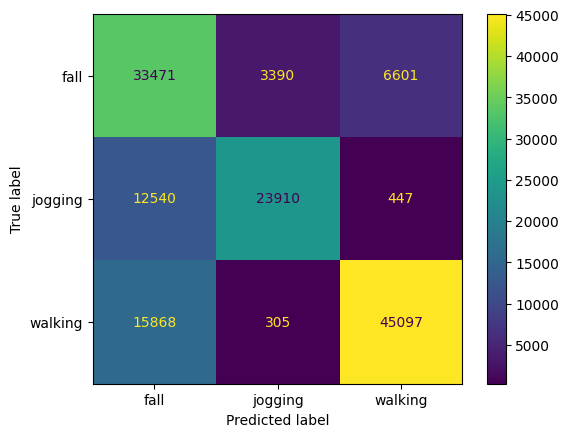

In [10]:
clf = DecisionTreeClassifier(random_state=42, max_depth=3, class_weight='balanced')
clf.fit(X_train, y_train)
cv = StratifiedKFold(n_splits=5, shuffle=False)
y_pred = cross_val_predict(clf, X, y, cv=cv, n_jobs=-1)

print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

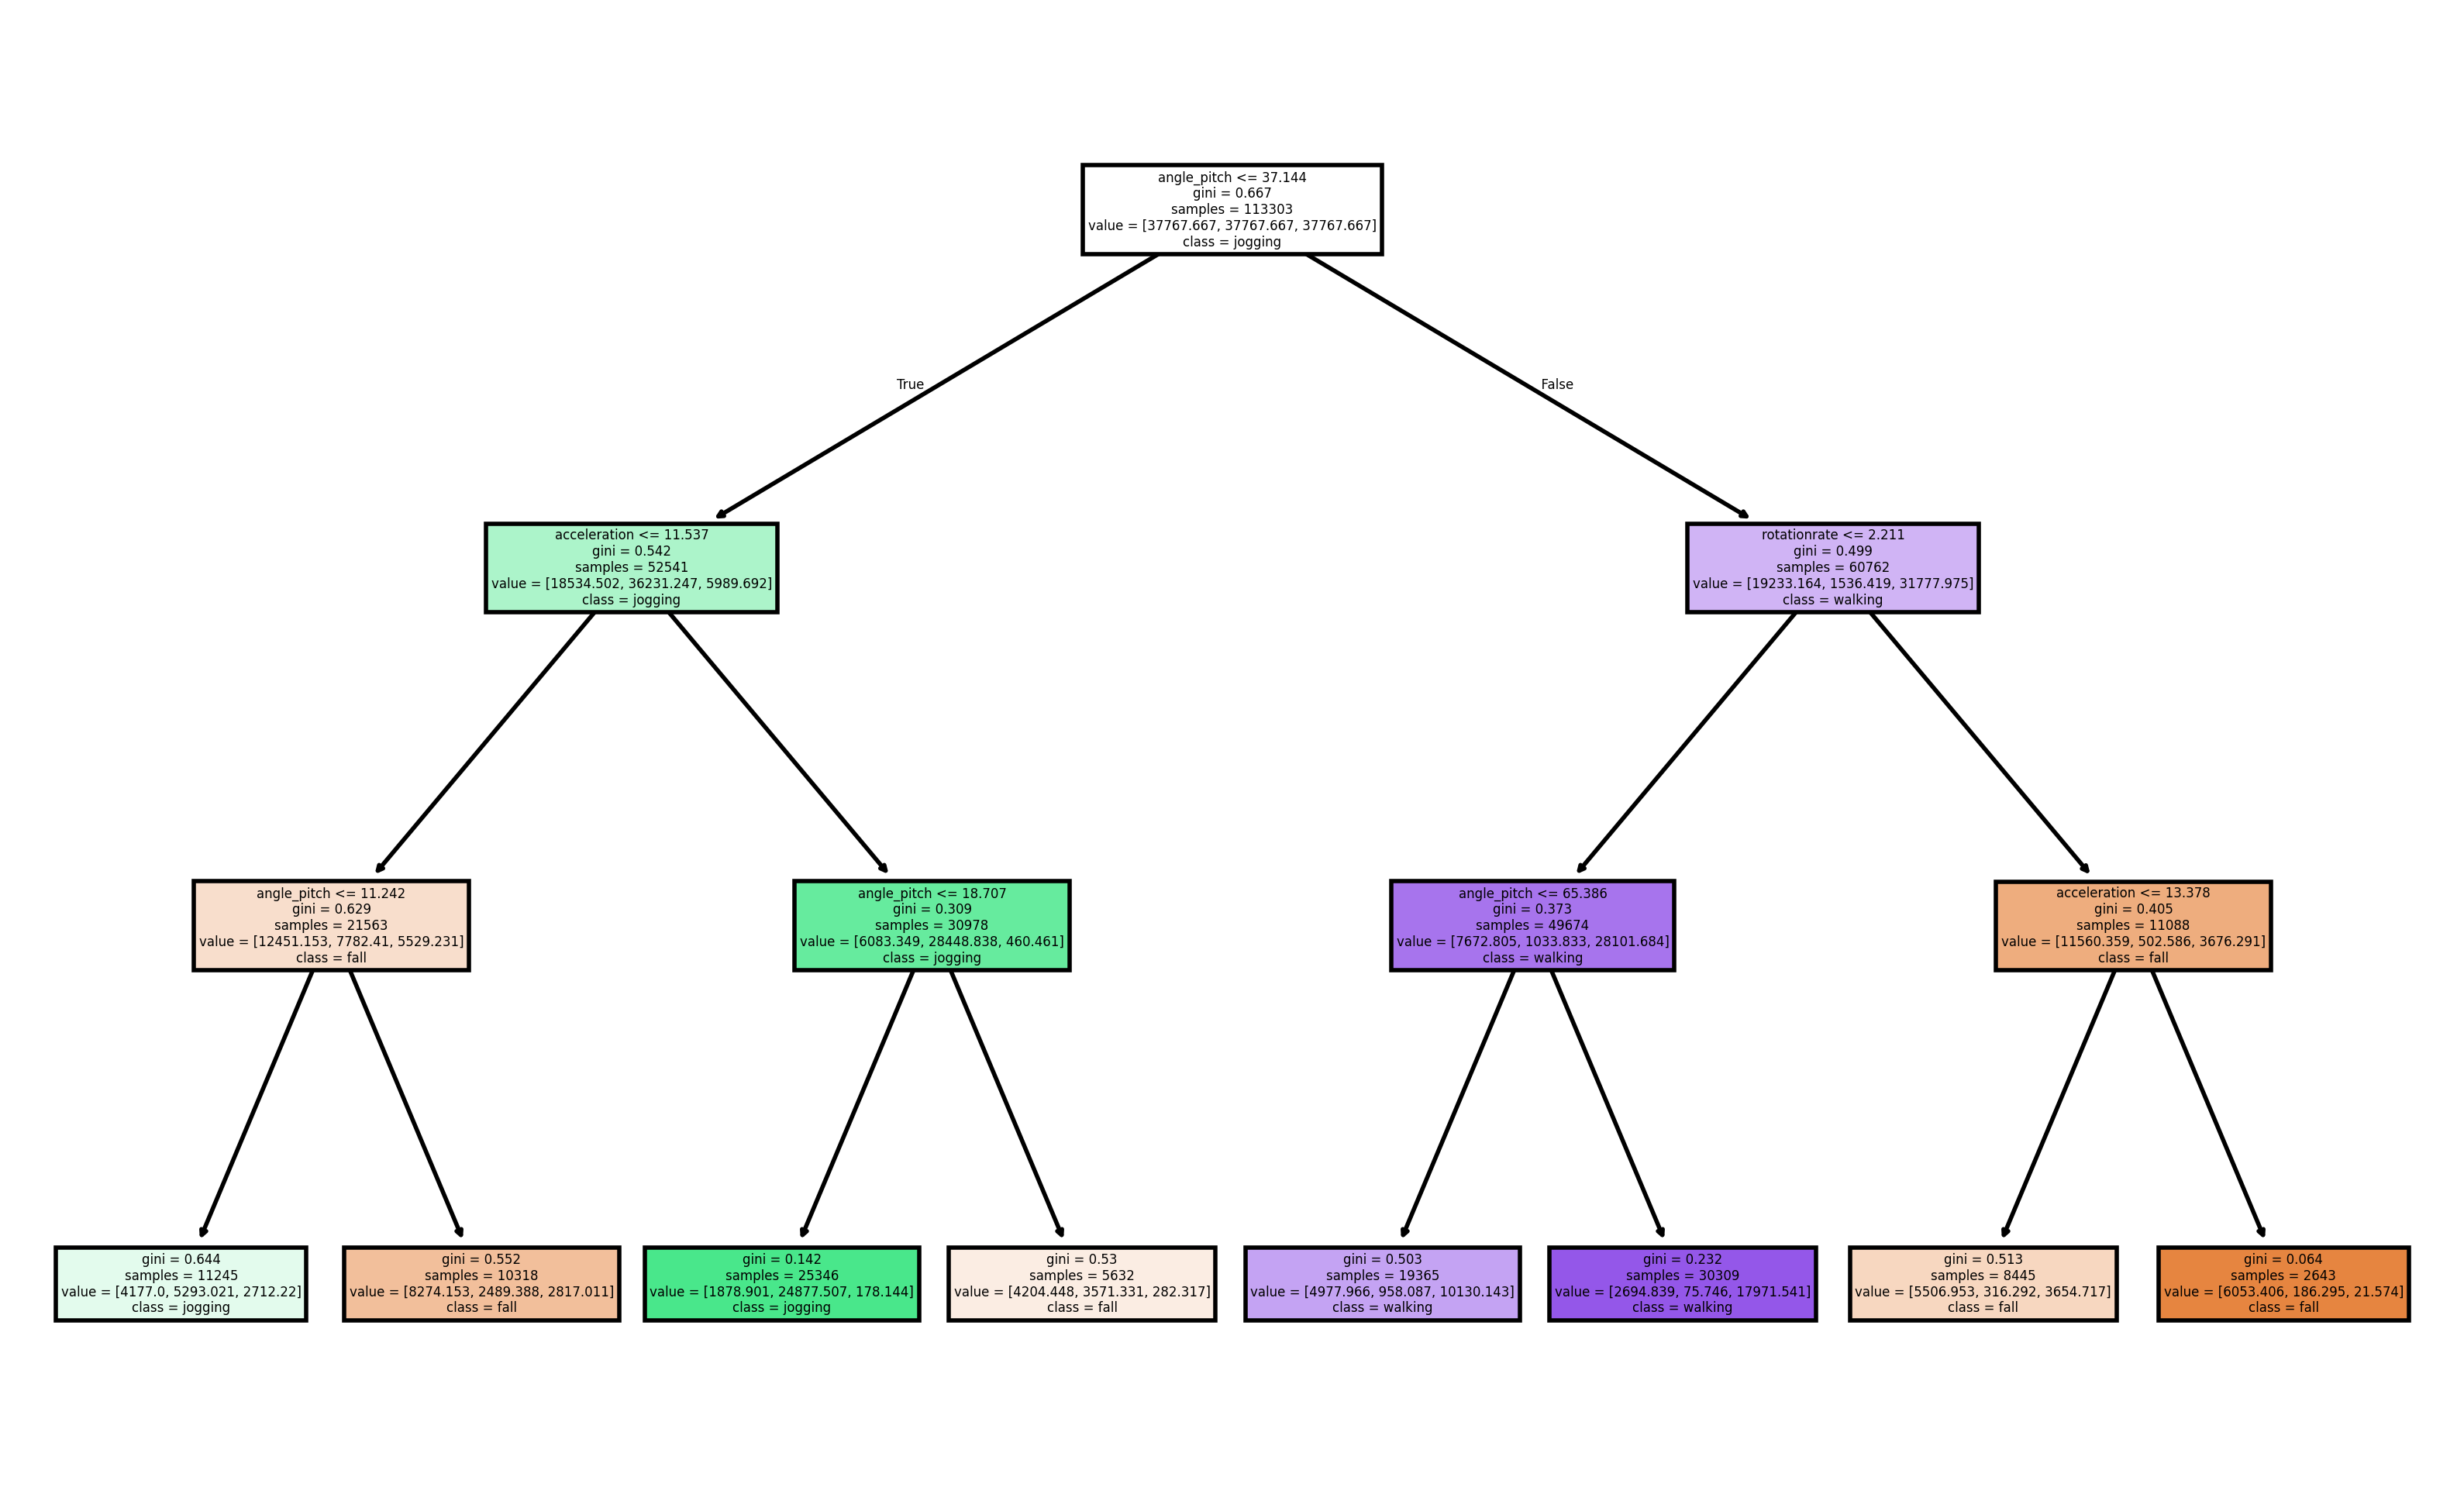

In [11]:
plt.figure(figsize=(10, 6), dpi=400)
plot_tree(clf, feature_names=X.columns, class_names=clf.classes_, filled=True)
plt.show()

In [12]:
# Extract rules
c_features = tree_to_rules(clf, X.columns)
print_rules(c_features)

Rules for class jogging:
  - angle_pitch <= 11.24 and acceleration <= 11.54
  - angle_pitch > 11.24 and angle_pitch <= 18.71 and acceleration > 11.54

Rules for class fall:
  - angle_pitch > 11.24 and angle_pitch <= 37.14 and acceleration <= 11.54
  - angle_pitch > 18.71 and angle_pitch <= 37.14 and acceleration > 11.54
  - angle_pitch > 65.39 and acceleration > 11.54 and acceleration <= 13.38 and rotationrate > 2.21
  - angle_pitch > 65.39 and acceleration > 13.38 and rotationrate > 2.21

Rules for class walking:
  - angle_pitch > 37.14 and angle_pitch <= 65.39 and acceleration > 11.54 and rotationrate <= 2.21
  - angle_pitch > 65.39 and acceleration > 11.54 and rotationrate <= 2.21



In [ ]:
def get_expressions(feature):
	l = []
	for dq in d[feature]:
		final_exp = []
		for dd in dq:
			if isinstance(dd, tuple):
				final_exp.append(f'{dd[0]} {dd[1]} {dd[2]}')
			else:
				match dd:
					case 'AND':
						final_exp.append('&&')
					case 'OR':
						final_exp.append('||')
					case _:
						final_exp.append(dd)
		l.append(' '.join(final_exp))
	return '\n'.join(l)

In [ ]:
for class_name in clf.classes_:
	print(class_name)
	print(get_expressions(class_name))
	print()

fall
angle_pitch <= 37.14 && acceleration <= 11.54 && angle_pitch > 11.24
angle_pitch <= 37.14 && acceleration > 11.54 && angle_pitch > 18.71
angle_pitch > 37.14 && rotationrate > 2.21 && acceleration <= 13.38
angle_pitch > 37.14 && rotationrate > 2.21 && acceleration > 13.38

jogging
angle_pitch <= 37.14 && acceleration <= 11.54 && angle_pitch <= 11.24
angle_pitch <= 37.14 && acceleration > 11.54 && angle_pitch <= 18.71

walking
angle_pitch > 37.14 && rotationrate <= 2.21 && angle_pitch <= 65.39
angle_pitch > 37.14 && rotationrate <= 2.21 && angle_pitch > 65.39

